In [2]:
import pandas as pd
import numpy as np 

In [3]:
train_data = pd.read_pickle('./raw_data/train.pickle')
test_data = pd.read_pickle('./raw_data/test.pickle')

In [4]:
num_data = train_data.cust_ip_no.value_counts()
ip_list = []
for i in num_data.index:
    ip_list.append(str(i))
    
    
using_ip = []
for i, j in num_data.iteritems():
    if j >= 10079:
        using_ip.append(i)
        

In [5]:
# 총 28개의 ip 실험
print(using_ip)
print(len(using_ip))

[8187.0, 11784.0, 10580.0, 10515.0, 10468.0, 9366.0, 10630.0, 10683.0, 9365.0, 8938.0, 8923.0, 8902.0, 11654.0, 8879.0, 10554.0, 11707.0, 8860.0, 11837.0, 8511.0, 8257.0, 12413.0, 8258.0, 8259.0, 12243.0, 11983.0, 8768.0, 11857.0, 8182.0]
28


In [6]:
# ddos 이력이 있는 ip 8939 추가, 총 29개 IP
using_ip.extend([8939])
print(using_ip)

[8187.0, 11784.0, 10580.0, 10515.0, 10468.0, 9366.0, 10630.0, 10683.0, 9365.0, 8938.0, 8923.0, 8902.0, 11654.0, 8879.0, 10554.0, 11707.0, 8860.0, 11837.0, 8511.0, 8257.0, 12413.0, 8258.0, 8259.0, 12243.0, 11983.0, 8768.0, 11857.0, 8182.0, 8939]


In [7]:
train_df = train_data[train_data.cust_ip_no.isin(using_ip)]
test_df = test_data[test_data.cust_ip_no.isin(using_ip)] 

In [8]:
print(train_df[train_df.event == 1].cust_ip_no.unique())
print(test_df[test_df.event == 1].cust_ip_no.unique())

[8938. 9365. 8923. 8939. 8879.]
[8938. 8923. 8939.]


In [9]:
train_list = [] 
for i in using_ip:
    df = train_df[train_df.cust_ip_no == i]
    df.reset_index(drop=True, inplace=True) 
    train_list.append(df)
    

test_list = []
for i in using_ip:
    df = test_df[test_df.cust_ip_no == i]
    df.reset_index(drop=True, inplace=True)
    test_list.append(df)    

In [10]:
from datetime import timedelta, datetime

# train data preprocessing
gap_dic = {}
for ip in range(len(train_list)):
    gap_list = []
    for data in range(len(train_list[ip])-1):
        gap = (datetime.strptime(str(train_list[ip].stamp_inserted[data+1]),'%Y%m%d%H%M%S')) - (datetime.strptime(str(train_list[ip].stamp_inserted[data]),'%Y%m%d%H%M%S'))
        if gap > timedelta(minutes=1):
            gap_list.append((data))
    gap_dic[train_list[ip].cust_ip_no[0]] = gap_list

    
for ip in gap_dic.keys():
    gap_list = []
    for i in gap_dic[ip] :
        gap_num = i - 5
        for j in range(6):
            gap_list.append(gap_num+j)
    gap_dic[ip] = gap_list

    
# test data preprocessing    
gap_dic_test = {}
for ip in range(len(test_list)):
    gap_list = []
    for data in range(len(test_list[ip])-1):
        gap = (datetime.strptime(str(test_list[ip].stamp_inserted[data+1]),'%Y%m%d%H%M%S')) - (datetime.strptime(str(test_list[ip].stamp_inserted[data]),'%Y%m%d%H%M%S'))
        if gap > timedelta(minutes=1):
            gap_list.append((data))
    gap_dic_test[test_list[ip].cust_ip_no[0]] = gap_list

    
for ip in gap_dic_test.keys():
    gap_list = []
    for i in gap_dic_test[ip] :
        gap_num = i -5
        for j in range(6):
            gap_list.append(gap_num+j)
    gap_dic_test[ip] = gap_list

In [11]:
# train: apply log function & diff

from tqdm import tqdm
seq_time = 6
iv = [ 'bytes', 'pkts',
       'sip_entropy', 'dip_entropy', 'spt_entropy', 'dpt_entropy',
       'proto_entropy', 'icmp_ratio', 'tcp_ratio', 'udp_ratio',
       'tcp_flags_entropy', 'domestic_ratio']
log_trans = [ 'bytes', 'pkts',
       'sip_entropy', 'dip_entropy', 'spt_entropy', 'dpt_entropy']

features = len(iv)

normal_X = []
normal_y = [] 

for j in tqdm(range(len(train_list))):
    normal_data = pd.DataFrame(columns=iv)
    normal_label = []
    ip = list(gap_dic.keys())[j]
    gap = gap_dic[ip]
    for i in range(len(train_list[j]) - seq_time):
        if i not in gap:
            input_x = train_list[j].iloc[i:i+seq_time,3:-1]
            input_x[log_trans] = input_x[log_trans]+.1 
            input_x[log_trans] = input_x[log_trans].apply(np.log)
            input_x = input_x.diff().iloc[1:,:]
            label = train_list[j].iloc[i+seq_time-1, -1]
            ip_NO = train_list[j].iloc[i+seq_time-1, 2]
            time = train_list[j].iloc[i+seq_time-1, 0]

            if label == 0:
                normal_data = pd.concat([normal_data, input_x], axis=0)
                ip_label_set = (time, ip_NO, label)            
                normal_label.append(ip_label_set) 

                
    normal_X.append(normal_data) 
    normal_y.append(normal_label)     

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [11:23<00:00, 23.56s/it]


In [12]:
from tqdm import tqdm

seq_time = 6
iv = [ 'bytes', 'pkts',
       'sip_entropy', 'dip_entropy', 'spt_entropy', 'dpt_entropy',
       'proto_entropy', 'icmp_ratio', 'tcp_ratio', 'udp_ratio',
       'tcp_flags_entropy', 'domestic_ratio']
log_trans = [ 'bytes', 'pkts',
       'sip_entropy', 'dip_entropy', 'spt_entropy', 'dpt_entropy',
       'tcp_flags_entropy', 'domestic_ratio']

features = len(iv)

X_ts = []
y_ts = [] 


for j in tqdm(range(len(test_list))):
    ts_data = pd.DataFrame(columns=iv)
    ts_label = []
    ip = list(gap_dic_test.keys())[j]
    gap = gap_dic_test[ip]
    
    
    for i in range(len(test_list[j]) - seq_time):
        if i not in gap:
            input_x = test_list[j].iloc[i:i+seq_time,3:-1]
            input_x[log_trans] = input_x[log_trans]+.1 
            input_x[log_trans] = input_x[log_trans].apply(np.log)
            input_x = input_x.diff().iloc[1:,:] 
            label = test_list[j].iloc[i+seq_time-1, -1]
            ip_NO = test_list[j].iloc[i+seq_time-1, 2]  
            time = test_list[j].iloc[i+seq_time-1, 0]
            
            ts_data = pd.concat([ts_data, input_x], axis=0)
            ip_label_set = (time, ip_NO, label)            
            ts_label.append(ip_label_set)         
        else: 
            pass
            
    X_ts.append(ts_data) 
    y_ts.append(ts_label) 

100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [11:40<00:00, 24.17s/it]


In [14]:
# train: data scaling 
from sklearn import preprocessing

X_normal = pd.DataFrame(columns=iv)
for i in normal_X:
    i = i.fillna(0)
    tmp_input = pd.DataFrame(preprocessing.scale(i.values), columns=iv)
    X_normal = pd.concat([X_normal, tmp_input], axis=0)

y_normal = []
for i in normal_y:
    y_normal.extend(i)

In [15]:
# test: data scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

X_ts_ = pd.DataFrame(columns=iv)
for i in X_ts:
    i = i.fillna(0)
    tmp_input = pd.DataFrame(preprocessing.scale(i.values), columns=iv)
    X_ts_ = pd.concat([X_ts_, tmp_input], axis=0)

y_ts_ = []
for i in y_ts:
    y_ts_.extend(i)


In [16]:
# data check
X_normal = X_normal.values.reshape(-1, 5, 12) 
train_y_df = pd.DataFrame(y_normal, columns=['time','ip','label'])
train_y_df.head()

,time,ip,label
0,20200801000500,8187.0,0.0
1,20200801000600,8187.0,0.0
2,20200801000700,8187.0,0.0
3,20200801000800,8187.0,0.0
4,20200801000900,8187.0,0.0


In [17]:
# test df
X_ts = X_ts_.values.reshape(-1, 5, 12) 
y_ts = pd.DataFrame(y_ts_, columns=['time','ip','label'])

### CVAE with attention

In [160]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import norm 
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Dropout, BatchNormalization
from keras.layers import Conv1D, Conv1DTranspose
from keras.models import Model, Sequential 
from keras import backend as K
from keras import objectives, metrics, layers
import keras
from keras.layers import Input, LSTM, RepeatVector, Bidirectional, TimeDistributed
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.optimizers import SGD, RMSprop, Adam

seq_time = 5

input_dim = features
timesteps = seq_time
latent_dim = 12
epsilon_std = 1.0
kernel_s = 3
adam = Adam(lr=1e-5)
lrelu = layers.LeakyReLU(alpha=0.3)
relu = layers.ReLU


x = Input(shape=(5, 12))
xx = Flatten()(x)

Enc = Sequential([x,
    layers.Conv1D(filters=36, kernel_size=kernel_s, padding='same', strides=1),
    #layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(filters=48, kernel_size=kernel_s, padding='same',strides=1),
    #layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv1D(filters=36, kernel_size=kernel_s, padding='same',strides=1),
    layers.ReLU(),
    layers.Flatten()]) 

z_mean1 = Dense(latent_dim)(Enc(x))  
z_log_var1 = Dense(latent_dim)(Enc(x)) 
z_mean2 = Dense(latent_dim)(Enc(x))  
z_log_var2 = Dense(latent_dim)(Enc(x)) 
z_mean3 = Dense(latent_dim)(Enc(x))  
z_log_var3 = Dense(latent_dim)(Enc(x)) 
attention = Dense(3, activation='softmax')(Enc(x))




def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                                stddev = 1.)
    return z_mean + K.exp(z_log_var/2) *epsilon



z1 = Lambda(sampling, output_shape=(latent_dim,))([z_mean1, z_log_var1])
z2 = Lambda(sampling, output_shape=(latent_dim,))([z_mean2, z_log_var2])
z3 = Lambda(sampling, output_shape=(latent_dim,))([z_mean3, z_log_var3])


z = (tf.reshape(attention[:,0], (-1,1))*z1 + tf.reshape(attention[:,1], (-1,1))*z2 
     + tf.reshape(attention[:,2], (-1,1))*z3 )


new_z =  Dense(60, activation='relu')(z)
new_z = tf.reshape(new_z,[-1, 5, 12])
Dec = Sequential([
    Conv1DTranspose(filters=36, kernel_size=kernel_s, padding='same', strides=1, activation='relu'),
    #ayers.BatchNormalization(),
    layers.Conv1DTranspose(filters=48, kernel_size=kernel_s, padding='same', strides=1, activation='relu'),
    #ayers.BatchNormalization(),
    #layers.Conv1DTranspose(filters=36, kernel_size=kernel_s, padding='same', strides=1, activation='relu'),
    #layers.BatchNormalization(),
    layers.Conv1DTranspose(filters=12, kernel_size=kernel_s, padding='same')])
    #layers.BatchNormalization()])


x_hat = Dec(new_z)
x_hh = Flatten()(x_hat) 

cvae = Model(x, x_hat) 
cvae.compile(optimizer=adam, loss='rmse')
cvae_encoder = Model(x, z)
#soft_m = Model(x, attention)
xent_loss = 100 * objectives.mse(xx, x_hh) 
kl_loss1 = -0.5 * K.sum(1+z_log_var1 - K.square(z_mean1) - K.exp(z_log_var1), axis=-1)
kl_loss2 = -0.5 * K.sum(1+z_log_var2 - K.square(z_mean2) - K.exp(z_log_var2), axis=-1)
kl_loss3 = -0.5 * K.sum(1+z_log_var3 - K.square(z_mean3) - K.exp(z_log_var3), axis=-1)
kl_loss = (kl_loss1 + kl_loss2 + kl_loss3)
vae_loss = K.mean(0.5*xent_loss + 0.5*kl_loss) 
cvae.add_loss(vae_loss) 
cvae.compile(optimizer=adam)  
#cvae.summary()

In [161]:
#60
hist = cvae.fit(X_normal, X_normal, epochs=50, validation_split=0.1, batch_size=128, shuffle=True, verbose=2)

Epoch 1/50
2052/2052 - 12s - loss: 60.3537 - val_loss: 50.3679
Epoch 2/50
2052/2052 - 10s - loss: 53.0131 - val_loss: 50.2193
Epoch 3/50
2052/2052 - 10s - loss: 51.6585 - val_loss: 50.1546
Epoch 4/50
2052/2052 - 10s - loss: 50.8944 - val_loss: 50.1074
Epoch 5/50
2052/2052 - 10s - loss: 50.5528 - val_loss: 50.0660
Epoch 6/50
2052/2052 - 10s - loss: 50.3718 - val_loss: 50.0291
Epoch 7/50
2052/2052 - 10s - loss: 50.2735 - val_loss: 49.9927
Epoch 8/50
2052/2052 - 10s - loss: 50.2115 - val_loss: 49.9607
Epoch 9/50
2052/2052 - 10s - loss: 50.1706 - val_loss: 49.9240
Epoch 10/50
2052/2052 - 10s - loss: 50.1304 - val_loss: 49.9017
Epoch 11/50
2052/2052 - 10s - loss: 50.0918 - val_loss: 49.8561
Epoch 12/50
2052/2052 - 10s - loss: 50.1015 - val_loss: 49.8182
Epoch 13/50
2052/2052 - 10s - loss: 49.9993 - val_loss: 49.6993
Epoch 14/50
2052/2052 - 10s - loss: 49.5717 - val_loss: 48.6586
Epoch 15/50
2052/2052 - 10s - loss: 48.4151 - val_loss: 47.7140
Epoch 16/50
2052/2052 - 10s - loss: 47.9397 - val

In [162]:
from plotly.offline import plot, iplot 
import plotly.graph_objects as go

loss = hist.history['loss'] 
val_loss = hist.history['val_loss'] 

fig = go.Figure()
fig.add_trace(go.Scatter(y=loss, mode='lines', name='loss')) 
fig.add_trace(go.Scatter(y=val_loss, mode='lines', name='val_loss'))
fig.update_layout(height=400, width=600, title='loss of CVAE')
fig.show() 

In [163]:
pred_x = cvae.predict(X_normal).reshape(X_normal.shape[0],-1)
real = X_normal.reshape(X_normal.shape[0], -1) 
log_mse = np.log(np.mean(np.power(real-pred_x, 2), axis=1)) 
mse = np.mean(np.power(real-pred_x, 2), axis=1)
train_df_error = pd.DataFrame({'time':train_y_df.time, 'recon_size':mse, 'IP':train_y_df.ip, 'reconstruction_error':log_mse, 'Label':train_y_df.label})


In [164]:
thr = train_df_error[['reconstruction_error','Label']].describe()
error = sorted(train_df_error.reconstruction_error.values, reverse=True)

up_to_99_5 = int(round(len(error) * 0.005,0)) 
up_to_99_5

threshold = error[up_to_99_5]
max_error = error[0]
print(thr)
print(threshold) 

       reconstruction_error     Label
count         291779.000000  291779.0
mean              -0.853624       0.0
std                0.884875       0.0
min               -4.551556       0.0
25%               -1.373619       0.0
50%               -0.839005       0.0
75%               -0.317093       0.0
max                6.153394       0.0
1.8043311570207106


In [165]:
from sklearn.metrics import confusion_matrix, classification_report

pred_x = cvae.predict(X_ts).reshape(X_ts.shape[0],-1)
real = X_ts.reshape(X_ts.shape[0], -1)
log_mse = np.log(np.mean(np.power(real-pred_x, 2), axis=1))
mse = np.mean(np.power(real-pred_x, 2), axis=1)
test_df_error = pd.DataFrame({'time':y_ts.time, 'reconstruction_error':log_mse, 'recon_size':mse, 'Label':y_ts.label, 'IP':y_ts.ip})



pred_y = [1 if e > threshold else 0 for e in test_df_error['reconstruction_error'].values]
confusion_m = confusion_matrix(y_ts.label, pred_y)
classification = classification_report(y_ts.label, pred_y)
test_df_error['predicted_y'] = pred_y
print(confusion_m)
print(classification)

[[289097   1834]
 [     1     77]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    290931
         1.0       0.04      0.99      0.08        78

    accuracy                           0.99    291009
   macro avg       0.52      0.99      0.54    291009
weighted avg       1.00      0.99      1.00    291009



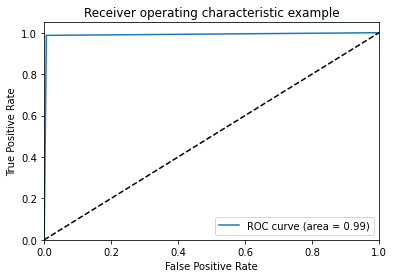

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve

fpr, tpr, thresholds = roc_curve(test_df_error.Label, pred_y)
roc_auc = auc(fpr, tpr)

plt.figure() 
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right") 
plt.show()

In [35]:
# # comparing the reconstruction distribution 
# import plotly.figure_factory as ff
# from plotly.offline import plot, iplot 

# test_ddos = test_df_error[test_df_error.Label ==1 ]
# test_normal = test_df_error[test_df_error.Label ==0 ]
# data = [train_df_error.reconstruction_error, test_ddos.reconstruction_error, test_normal.reconstruction_error]
# group = ['train normal', 'test ddos', 'test normal'] 
# fig = ff.create_distplot(data, group, bin_size=[.2,.2,.2])
# fig.update_layout(title='Reconstruction distribution') 
# fig.show() 